In [1]:
import sqlite3
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [2]:
conn = sqlite3.connect("fifa23_dashboard/data/fifa23.db")

In [3]:
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(tables)

                           name
0                       players
1  players_fifa23_with_clusters
2                players_fifa23


In [4]:
query = """
SELECT "Best Position", COUNT(*) AS total_players
FROM players_fifa23
GROUP BY "Best Position"
ORDER BY total_players DESC
"""
count_players_position = pd.read_sql_query(query, conn)
count_players_position

,Best Position,total_players
0,CB,3658
1,ST,2565
2,CAM,2311
3,GK,2061
4,RM,1443
5,CDM,1403
6,CM,1104
7,RB,925
8,LB,864
9,LM,797


In [5]:
df = pd.read_sql_query("SELECT * FROM players_fifa23", conn)

In [7]:
df['GroupedPosition'] = df['Best Position'].replace({
    'ST': 'ST_CF', 'CF': 'ST_CF',
    'RW': 'RM_RW', 'RM': 'RM_RW',
    'RB': 'RB_RWB', 'RWB': 'RB_RWB',
    'LB': 'LB_LWB', 'LWB': 'LB_LWB',
    'LM': 'LM_LW', 'LW': 'LM_LW',
})

In [8]:
df.to_sql("players_fifa23", conn, if_exists="replace", index=False)

18539

In [9]:
conn.close()

In [10]:
df

,player_id,Known As,Full Name,Overall,Potential,Value(in Euro),Positions Played,Best Position,Nationality,Image Link,...,CM Rating,RM Rating,LWB Rating,CDM Rating,RWB Rating,LB Rating,CB Rating,RB Rating,GK Rating,GroupedPosition
0,1,L. Messi,Lionel Messi,91,91,54000000,RW,CAM,Argentina,https://cdn.sofifa.net/players/158/023/23_60.png,...,88,91,67,66,67,62,53,62,22,CAM
1,2,K. Benzema,Karim Benzema,91,91,64000000,"CF,ST",CF,France,https://cdn.sofifa.net/players/165/153/23_60.png,...,84,89,67,67,67,63,58,63,21,ST_CF
2,3,R. Lewandowski,Robert Lewandowski,91,91,84000000,ST,ST,Poland,https://cdn.sofifa.net/players/188/545/23_60.png,...,83,86,67,69,67,64,63,64,22,ST_CF
3,4,K. De Bruyne,Kevin De Bruyne,91,91,107500000,"CM,CAM",CM,Belgium,https://cdn.sofifa.net/players/192/985/23_60.png,...,91,91,82,82,82,78,72,78,24,CM
4,5,K. Mbappé,Kylian Mbappé,91,95,190500000,"ST,LW",ST,France,https://cdn.sofifa.net/players/231/747/23_60.png,...,84,92,70,66,70,66,57,66,21,ST_CF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18534,18535,D. Collins,Darren Collins,47,56,110000,"ST,RM",CAM,Republic of Ireland,https://cdn.sofifa.net/players/243/725/23_60.png,...,44,50,41,38,41,40,36,40,15,CAM
18535,18536,Yang Dejiang,Dejiang Yang,47,57,90000,CDM,CDM,China PR,https://cdn.sofifa.net/players/261/933/23_60.png,...,45,45,47,48,47,49,49,49,15,CDM
18536,18537,L. Mullan,Liam Mullan,47,67,130000,CM,RM,Northern Ireland,https://cdn.sofifa.net/players/267/823/23_60.png,...,49,52,46,44,46,46,42,46,17,RM_RW
18537,18538,D. McCallion,Daithí McCallion,47,61,100000,CB,CB,Republic of Ireland,https://cdn.sofifa.net/players/267/824/23_60.png,...,33,33,44,42,44,47,49,47,15,CB


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18539 entries, 0 to 18538
Data columns (total 91 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   player_id                    18539 non-null  int64 
 1   Known As                     18539 non-null  object
 2   Full Name                    18539 non-null  object
 3   Overall                      18539 non-null  int64 
 4   Potential                    18539 non-null  int64 
 5   Value(in Euro)               18539 non-null  int64 
 6   Positions Played             18539 non-null  object
 7   Best Position                18539 non-null  object
 8   Nationality                  18539 non-null  object
 9   Image Link                   18539 non-null  object
 10  Age                          18539 non-null  int64 
 11  Height(in cm)                18539 non-null  int64 
 12  Weight(in kg)                18539 non-null  int64 
 13  TotalStats                   18

In [12]:

numeric_features = [
    #'Weak Foot Rating', 'Skill Moves', 'International Reputation',
    'Pace Total', 'Shooting Total', 'Passing Total', 'Dribbling Total',
    'Defending Total', 'Physicality Total', 'Crossing', 'Finishing',
    'Heading Accuracy', 'Short Passing', 'Volleys', 'Dribbling', 'Curve',
    'Freekick Accuracy', 'LongPassing', 'BallControl', 'Acceleration',
    'Sprint Speed', 'Agility', 'Reactions', 'Balance', 'Shot Power',
    'Jumping', 'Stamina', 'Strength', 'Long Shots', 'Aggression',
    'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
    'Marking', 'Standing Tackle', 'Sliding Tackle', 'Goalkeeper Diving',
    'Goalkeeper Handling', 'GoalkeeperKicking', 'Goalkeeper Positioning',
    'Goalkeeper Reflexes', #'ST Rating', 'LW Rating', 'LF Rating', 'CF Rating',
    #'RF Rating', 'RW Rating', 'CAM Rating', 'LM Rating', 'CM Rating', 
    #'RM Rating', 'LWB Rating', 'CDM Rating', 'RWB Rating', 'LB Rating', 
    #'CB Rating', 'RB Rating', 'GK Rating'
]


numeric_features = [f for f in numeric_features if f in df.columns]


df_filtered = df.dropna(subset=numeric_features + ['GroupedPosition', 'Overall'])

In [13]:

models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Linear Regression": LinearRegression()
}




all_results = []


for position in df_filtered['GroupedPosition'].unique():
    print(f"\n🔍 Position: {position}")
    df_pos = df_filtered[df_filtered['GroupedPosition'] == position]

    X = df_pos[numeric_features]
    y = df_pos['Overall']

    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42
    )

    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

       
        all_results.append({
            'Position': position,
            'Model': name,
            'RMSE': round(rmse, 2),
            'R2 Score': round(r2, 2)
        })



🔍 Position: CAM

🔍 Position: ST_CF

🔍 Position: CM

🔍 Position: RM_RW

🔍 Position: GK

🔍 Position: CB

🔍 Position: LM_LW

🔍 Position: CDM

🔍 Position: LB_LWB

🔍 Position: RB_RWB


In [14]:

results_df = pd.DataFrame(all_results)


results_df = results_df.sort_values(by=['Position', 'RMSE'])
print(results_df)

   Position              Model  RMSE  R2 Score
2       CAM  Linear Regression  0.78      0.99
0       CAM      Random Forest  1.07      0.98
1       CAM      Decision Tree  1.77      0.94
17       CB  Linear Regression  0.50      0.99
15       CB      Random Forest  0.81      0.99
16       CB      Decision Tree  1.27      0.96
23      CDM  Linear Regression  1.01      0.97
21      CDM      Random Forest  1.23      0.96
22      CDM      Decision Tree  1.88      0.91
8        CM  Linear Regression  0.54      0.99
6        CM      Random Forest  0.92      0.98
7        CM      Decision Tree  1.85      0.93
14       GK  Linear Regression  0.32      1.00
12       GK      Random Forest  0.67      0.99
13       GK      Decision Tree  1.42      0.96
26   LB_LWB  Linear Regression  0.42      1.00
24   LB_LWB      Random Forest  0.94      0.98
25   LB_LWB      Decision Tree  1.71      0.92
20    LM_LW  Linear Regression  0.71      0.99
18    LM_LW      Random Forest  1.16      0.97
19    LM_LW  

In [15]:

results_linear = []
feature_graphs_linear = []


for position in df_filtered['GroupedPosition'].unique():
    print(f"\n🔍 Position: {position}")
    df_pos = df_filtered[df_filtered['GroupedPosition'] == position]
    X = df_pos[numeric_features]
    y = df_pos['Overall']

    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42
    )

   
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

   
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"RMSE: {rmse:.2f} | R²: {r2:.2f}")

    
    results_linear.append({
        'Position': position,
        'RMSE': round(rmse, 2),
        'R2 Score': round(r2, 2)
    })

    
    coef_series = pd.Series(model.coef_, index=X.columns)
    top5 = coef_series.abs().sort_values(ascending=False).head(5)
    top5_named = coef_series[top5.index]  
    feature_graphs_linear.append((position, "Linear Regression", top5_named))


results_linear_df = pd.DataFrame(results_linear).sort_values(by='RMSE')
print("\n📊 Linear Regression Results:")
print(results_linear_df)


🔍 Position: CAM
RMSE: 0.78 | R²: 0.99

🔍 Position: ST_CF
RMSE: 0.51 | R²: 0.99

🔍 Position: CM
RMSE: 0.54 | R²: 0.99

🔍 Position: RM_RW
RMSE: 0.92 | R²: 0.98

🔍 Position: GK
RMSE: 0.32 | R²: 1.00

🔍 Position: CB
RMSE: 0.50 | R²: 0.99

🔍 Position: LM_LW
RMSE: 0.71 | R²: 0.99

🔍 Position: CDM
RMSE: 1.01 | R²: 0.97

🔍 Position: LB_LWB
RMSE: 0.42 | R²: 1.00

🔍 Position: RB_RWB
RMSE: 0.61 | R²: 0.99

📊 Linear Regression Results:
  Position  RMSE  R2 Score
4       GK  0.32      1.00
8   LB_LWB  0.42      1.00
5       CB  0.50      0.99
1    ST_CF  0.51      0.99
2       CM  0.54      0.99
9   RB_RWB  0.61      0.99
6    LM_LW  0.71      0.99
0      CAM  0.78      0.99
3    RM_RW  0.92      0.98
7      CDM  1.01      0.97



📌 Charts Importance of Features:


C:\Users\lpraz\AppData\Local\Temp\ipykernel_7348\1507808048.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="coolwarm")


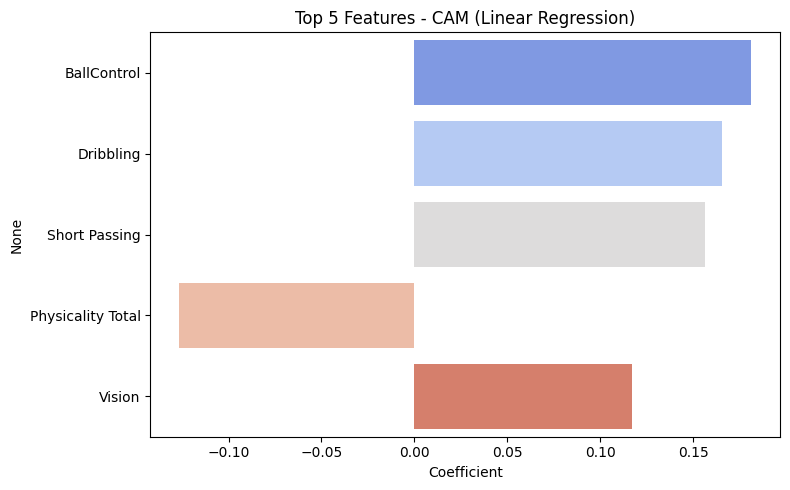

C:\Users\lpraz\AppData\Local\Temp\ipykernel_7348\1507808048.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="coolwarm")


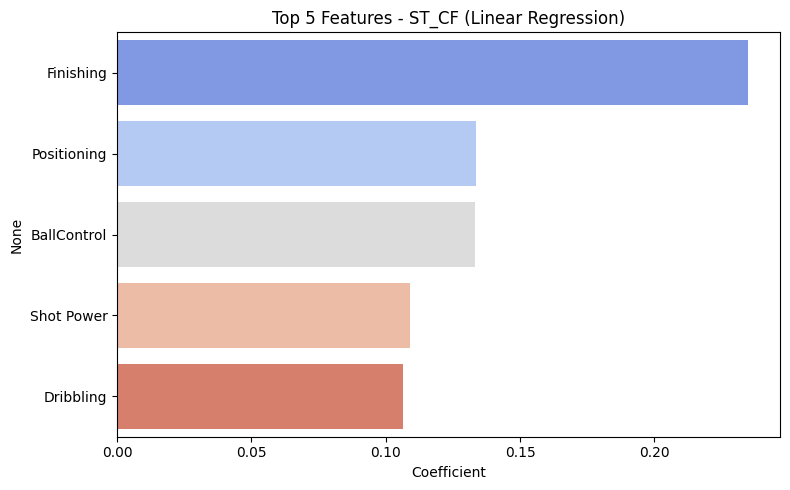

C:\Users\lpraz\AppData\Local\Temp\ipykernel_7348\1507808048.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="coolwarm")


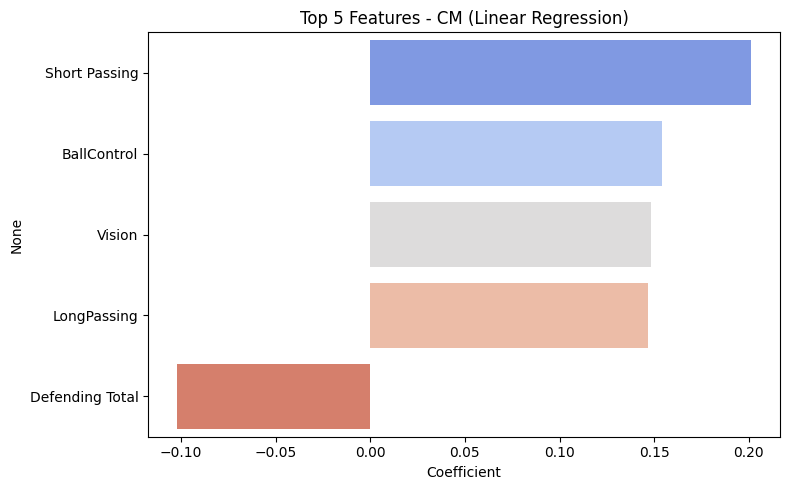

C:\Users\lpraz\AppData\Local\Temp\ipykernel_7348\1507808048.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="coolwarm")


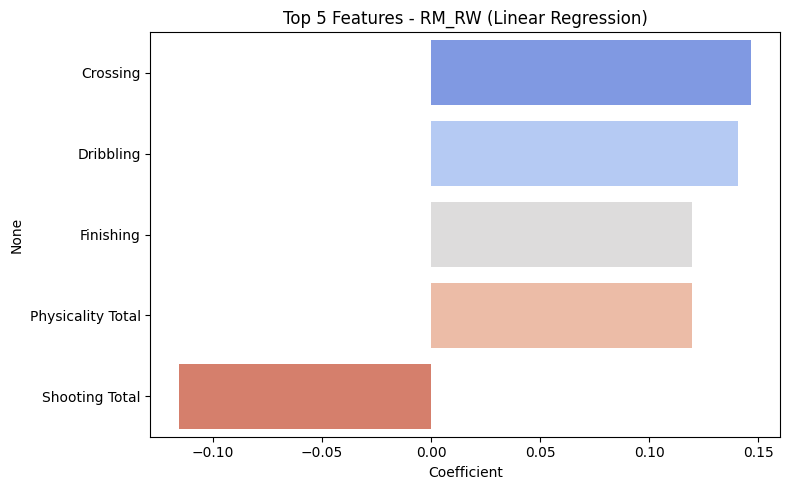

C:\Users\lpraz\AppData\Local\Temp\ipykernel_7348\1507808048.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="coolwarm")


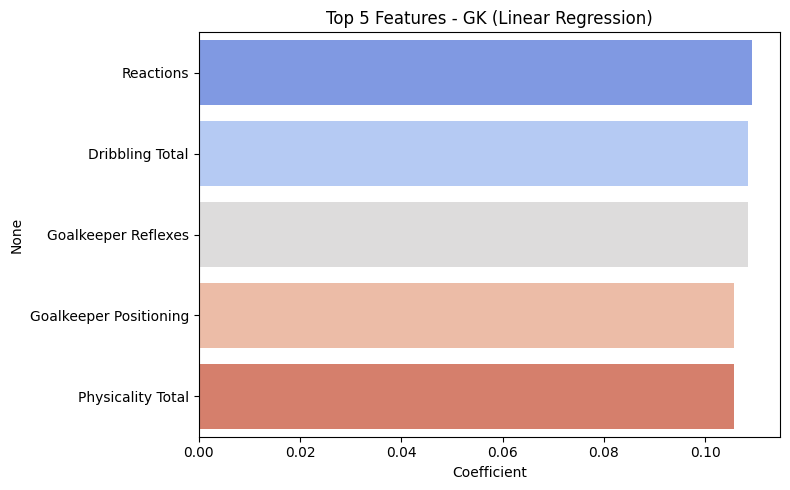

C:\Users\lpraz\AppData\Local\Temp\ipykernel_7348\1507808048.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="coolwarm")


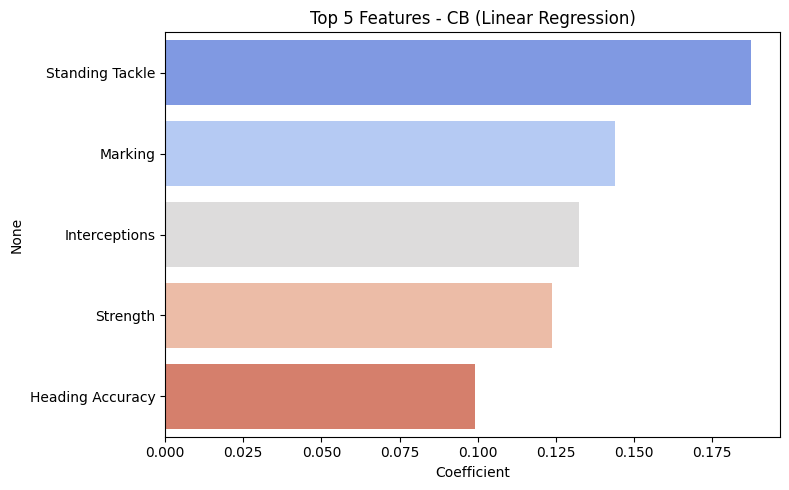

C:\Users\lpraz\AppData\Local\Temp\ipykernel_7348\1507808048.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="coolwarm")


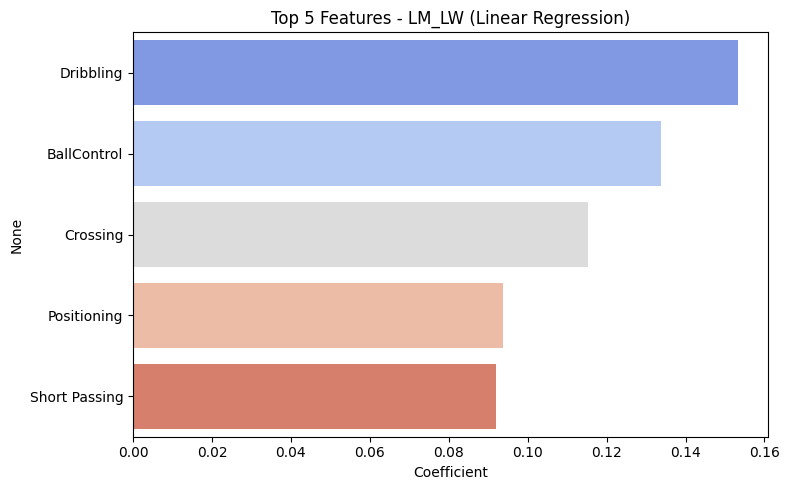

C:\Users\lpraz\AppData\Local\Temp\ipykernel_7348\1507808048.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="coolwarm")


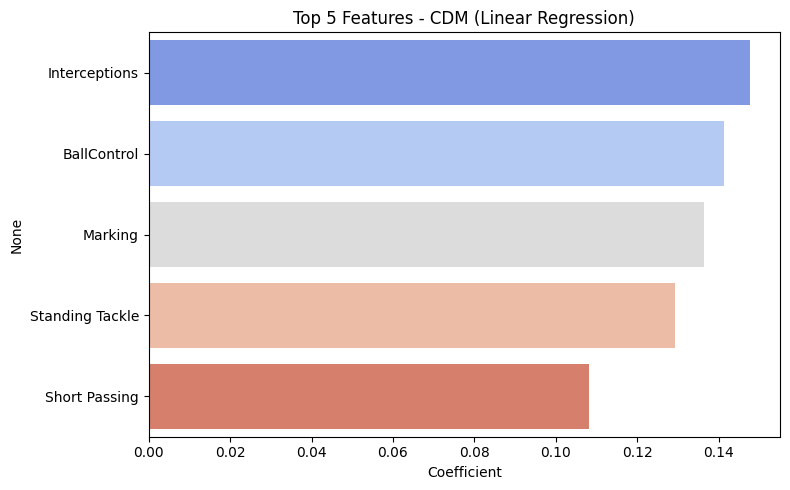

C:\Users\lpraz\AppData\Local\Temp\ipykernel_7348\1507808048.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="coolwarm")


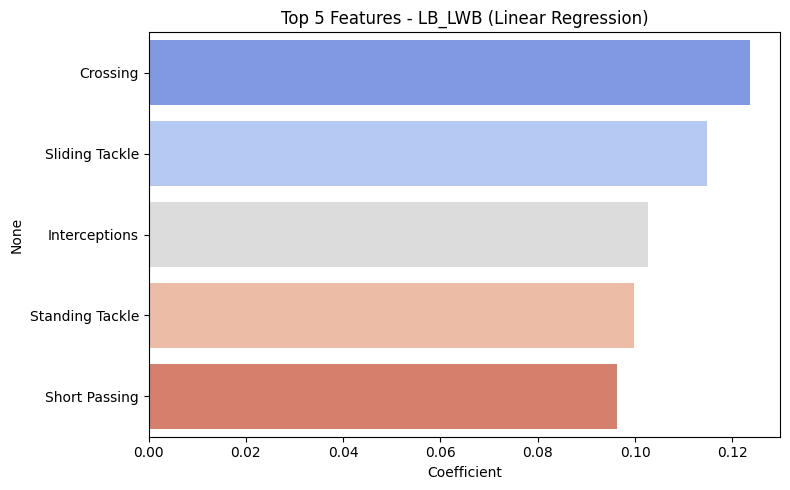

C:\Users\lpraz\AppData\Local\Temp\ipykernel_7348\1507808048.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="coolwarm")


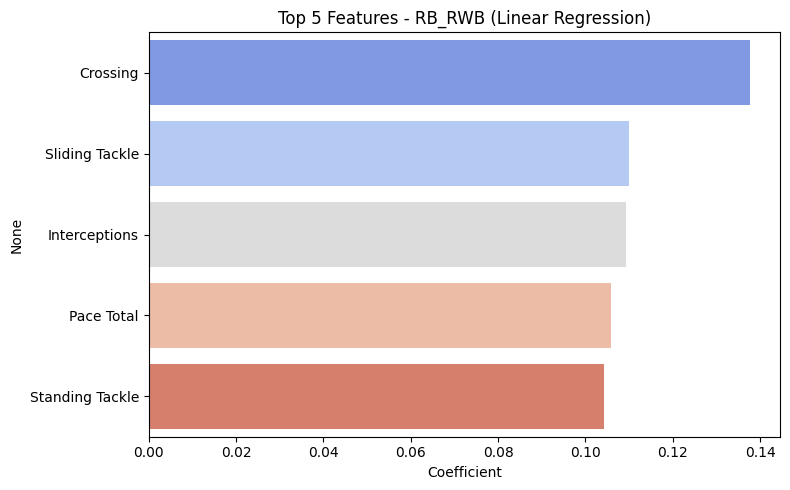

In [16]:

print("\n📌 Charts Importance of Features:")
for position, model_name, top_features in feature_graphs_linear:
    plt.figure(figsize=(8, 5))
    sns.barplot(x=top_features.values, y=top_features.index, palette="coolwarm")
    plt.title(f'Top 5 Features - {position} ({model_name})')
    plt.xlabel('Coefficient')
    plt.tight_layout()
    plt.show()